In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from mlxtend.frequent_patterns import apriori, association_rules

from Algorytmy_eksploracji_danych.lab10 import features

In [42]:
df_2009_2010 = pd.read_excel('data\online_retail_II.xlsx')
df_2010_2011 = pd.read_excel('data\online_retail_II.xlsx', sheet_name='Year 2010-2011')
df = pd.concat([df_2009_2010, df_2010_2011], ignore_index=True)
df.head()

<>:1: SyntaxWarning: invalid escape sequence '\o'
<>:2: SyntaxWarning: invalid escape sequence '\o'
<>:1: SyntaxWarning: invalid escape sequence '\o'
<>:2: SyntaxWarning: invalid escape sequence '\o'
C:\Users\mateuszlamla\AppData\Local\Temp\ipykernel_7020\949266689.py:1: SyntaxWarning: invalid escape sequence '\o'
  df_2009_2010 = pd.read_excel('data\online_retail_II.xlsx')
C:\Users\mateuszlamla\AppData\Local\Temp\ipykernel_7020\949266689.py:2: SyntaxWarning: invalid escape sequence '\o'
  df_2010_2011 = pd.read_excel('data\online_retail_II.xlsx', sheet_name='Year 2010-2011')


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [43]:
df.dropna(subset=['Customer ID'], inplace=True)
df = df[df['Quantity'] > 0]
df['TotalSum'] = df['Quantity'] * df['Price']
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 805620 entries, 0 to 1067370
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      805620 non-null  object        
 1   StockCode    805620 non-null  object        
 2   Description  805620 non-null  object        
 3   Quantity     805620 non-null  int64         
 4   InvoiceDate  805620 non-null  datetime64[ns]
 5   Price        805620 non-null  float64       
 6   Customer ID  805620 non-null  float64       
 7   Country      805620 non-null  object        
 8   TotalSum     805620 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 61.5+ MB


In [46]:
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

rfm = df.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'Invoice': 'nunique',
    'TotalSum': 'sum',
    'StockCode': 'nunique'
}).reset_index()

rfm.columns = ['CustomerID','Recency', 'Frequency', 'Monetary', 'Variety']
rfm.head()

,CustomerID,Recency,Frequency,Monetary,Variety
0,12346.0,326,12,77556.46,27
1,12347.0,2,8,5633.32,126
2,12348.0,75,5,2019.40,25
3,12349.0,19,4,4428.69,138
4,12350.0,310,1,334.40,17


In [48]:
features_to_scale = ['Recency', 'Frequency', 'Monetary', 'Variety']
rfm_log = rfm[features_to_scale].apply(np.log1p)

scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_log)

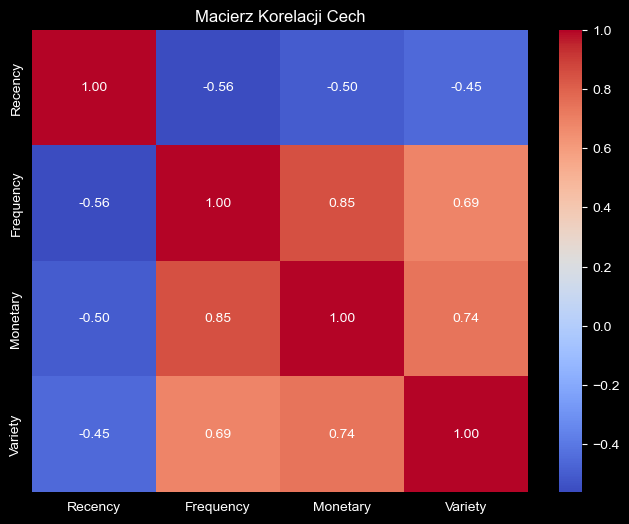

In [49]:
correlation_matrix = pd.DataFrame(rfm_scaled, columns=features_to_scale).corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Macierz Korelacji Cech')
plt.show()

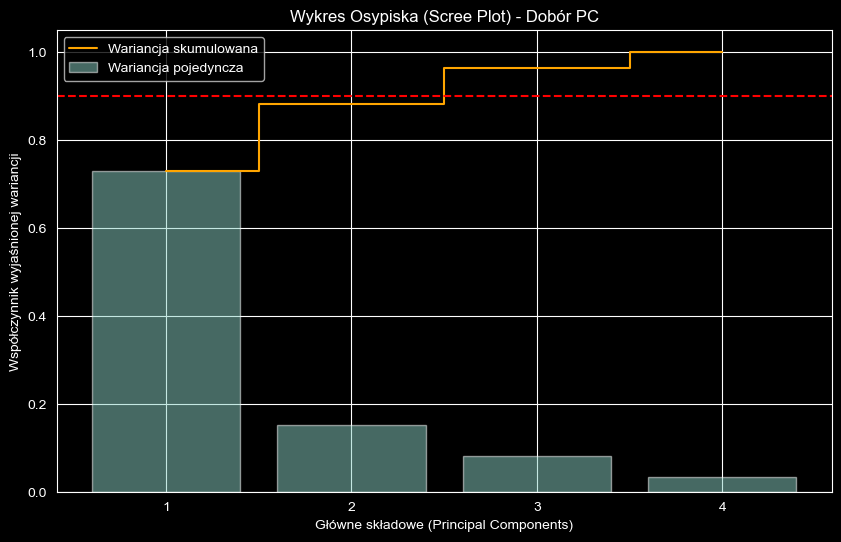

In [50]:
pca_test = PCA()
pca_test.fit(rfm_scaled)

# Wyliczamy wariancję
explained_variance = pca_test.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Rysujemy Wykres Osypiska (Scree Plot)
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance)+1), explained_variance, alpha=0.5, align='center', label='Wariancja pojedyncza')
plt.step(range(1, len(cumulative_variance)+1), cumulative_variance, where='mid', label='Wariancja skumulowana', color='orange')
plt.ylabel('Współczynnik wyjaśnionej wariancji')
plt.xlabel('Główne składowe (Principal Components)')
plt.title('Wykres Osypiska (Scree Plot) - Dobór PC')
plt.legend(loc='best')
plt.xticks(range(1, len(explained_variance)+1))
plt.axhline(y=0.90, color='r', linestyle='--', label='Próg 90%') # Linia pomocnicza
plt.show()

Wybieramy 2 główne składowe (PC1 i PC2), które razem wyjaśniają znaczną część wariancji w danych.

In [33]:
pca = PCA(n_components=3)
pca_components = pca.fit_transform(rfm_scaled)

customer_data['PC1'] = pca_components[:, 0]
customer_data['PC2'] = pca_components[:, 1]

variance_ratio = pca.explained_variance_ratio_
print(f"\n[PCA] Wyjaśniona wariancja: PC1={variance_ratio[0]:.2%}, PC2={variance_ratio[1]:.2%}")
print(f"[PCA] Łącznie wyjaśniono: {sum(variance_ratio):.2%} informacji.")


[PCA] Wyjaśniona wariancja: PC1=81.41%, PC2=12.81%
[PCA] Łącznie wyjaśniono: 94.22% informacji.


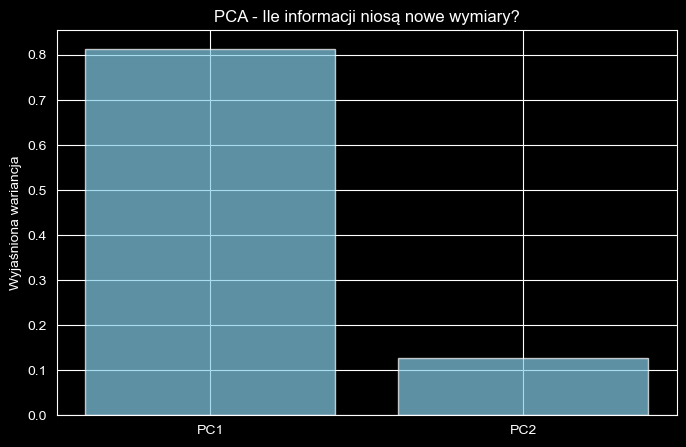

In [34]:
plt.figure(figsize=(8, 5))
plt.bar(['PC1', 'PC2'], variance_ratio, color='skyblue', alpha=0.7)
plt.title('PCA - Ile informacji niosą nowe wymiary?')
plt.ylabel('Wyjaśniona wariancja')
plt.show()

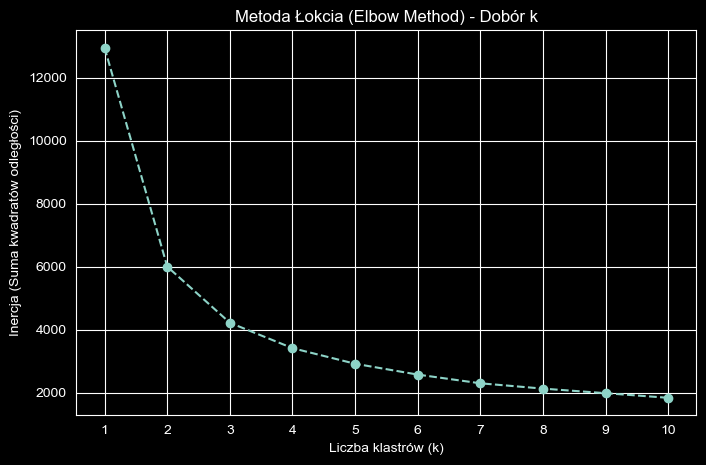

In [35]:
inertia = []
k_range = range(1, 11) # Sprawdzamy od 1 do 10 klastrów

for k in k_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(rfm_scaled) # Ważne: klastrujemy na danych skalowanych (lub na wynikach PCA)
    inertia.append(km.inertia_)

# Rysujemy wykres metody łokcia
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o', linestyle='--')
plt.xlabel('Liczba klastrów (k)')
plt.ylabel('Inercja (Suma kwadratów odległości)')
plt.title('Metoda Łokcia (Elbow Method) - Dobór k')
plt.xticks(k_range)
plt.show()

In [36]:
kmeans = KMeans(n_clusters=3, random_state=42)
customer_data['Cluster'] = kmeans.fit_predict(rfm_scaled)


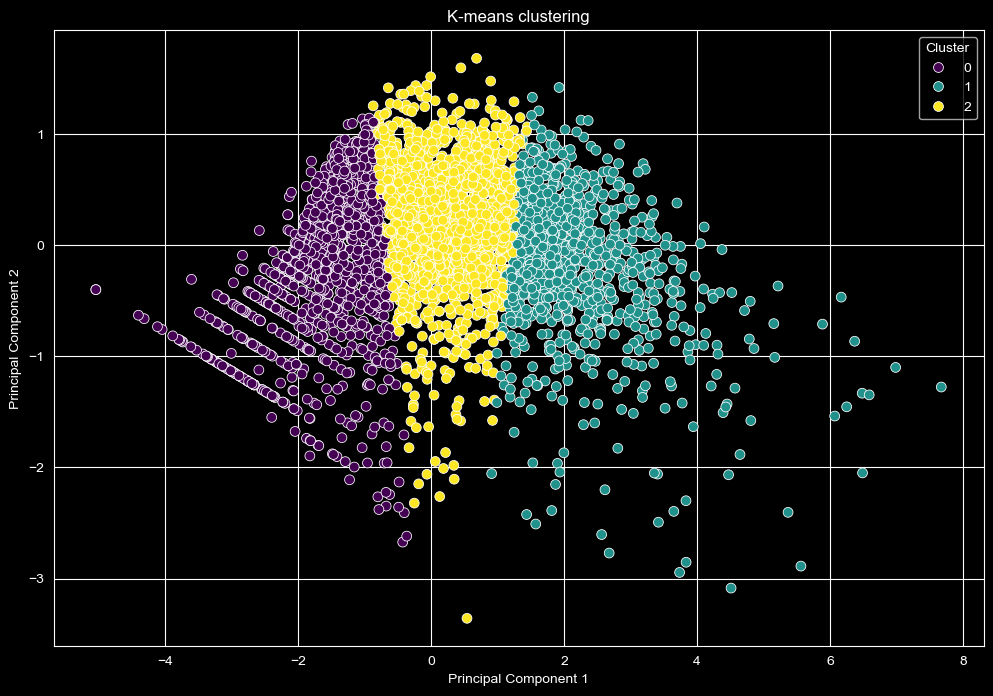

In [37]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=customer_data, palette='viridis', s=50)
plt.title('K-means clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

In [38]:
print(f"Cluster characteristics:")
print(customer_data.groupby('Cluster')[['Frequency', 'Monetary', 'Variety']].mean())

Cluster characteristics:
         Frequency     Monetary     Variety
Cluster                                    
0         1.304707   298.151387   14.925573
1        12.294118  6762.267625  156.414916
2         3.050279  1075.771237   57.027374


In [39]:
basket_data = df[df['Country'] == 'France']
basket = (basket_data.groupby(['Invoice', 'Description'])['Quantity']
          .sum().unstack().reset_index().fillna(0).set_index('Invoice'))

basket_sets = basket.applymap(lambda x: 1 if x >= 1 else 0)
if 'POSTAGE' in basket_sets.columns: basket_sets.drop('POSTAGE', inplace=True, axis=1)

C:\Users\mateuszlamla\AppData\Local\Temp\ipykernel_7020\2551366728.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  basket_sets = basket.applymap(lambda x: 1 if x >= 1 else 0)


In [40]:
frequent_itemsets = apriori(basket_sets, min_support=0.07, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)

print("\n[Apriori] Przykładowe silne reguły:")
rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].sort_values('lift', ascending=False).head(5)


[Apriori] Przykładowe silne reguły:


C:\Users\mateuszlamla\miniconda3\envs\SEMESTR5\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:175: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,antecedents,consequents,support,confidence,lift
29,(SET/6 RED SPOTTY PAPER PLATES),(SET/6 RED SPOTTY PAPER CUPS),0.101695,0.827586,6.103448
28,(SET/6 RED SPOTTY PAPER CUPS),(SET/6 RED SPOTTY PAPER PLATES),0.101695,0.750000,6.103448
4,(DOLLY GIRL LUNCH BOX),(SPACEBOY LUNCH BOX ),0.072034,0.809524,5.970238
5,(SPACEBOY LUNCH BOX ),(DOLLY GIRL LUNCH BOX),0.072034,0.531250,5.970238
2,(CIRCUS PARADE LUNCH BOX ),(SPACEBOY LUNCH BOX ),0.088983,0.750000,5.531250


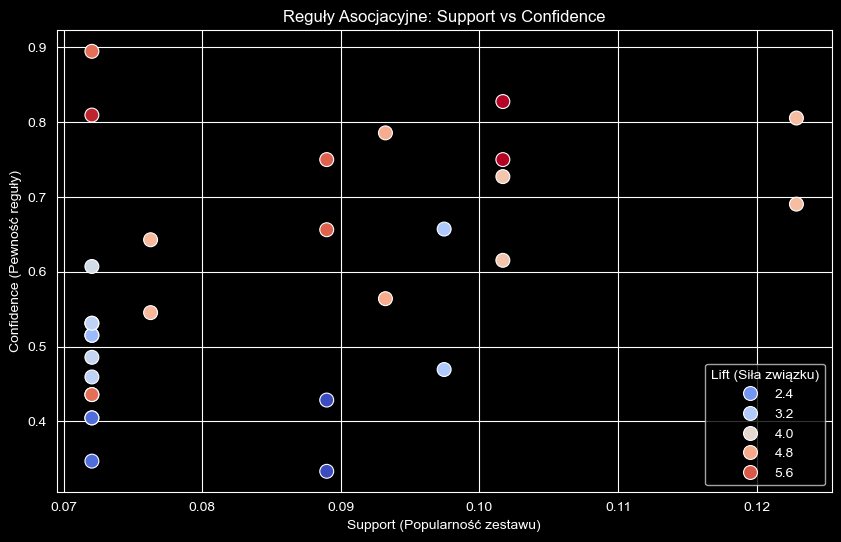

In [41]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=rules['support'], y=rules['confidence'], hue=rules['lift'], palette='coolwarm', s=100)
plt.title('Reguły Asocjacyjne: Support vs Confidence')
plt.xlabel('Support (Popularność zestawu)')
plt.ylabel('Confidence (Pewność reguły)')
plt.legend(title='Lift (Siła związku)')
plt.show()